In [11]:
from collections import Counter
from google.colab import drive
from prettytable import PrettyTable

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import torch

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/context-projections-pushright

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/context-projections-pushright


# Model Class

In [14]:
from model import Model

# Functions

In [15]:
from utils import preprocess, cosine_similarity, orthogonal_projection_position, kmeans_cluster, get_context_projections, get_stats

# Read Text

In [16]:
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: %d" % (len(words)))
print("Unique words in text: %d" % (len(set(words))))

Total words in text: 8448361
Unique words in text: 63459


## Choosing Test Words

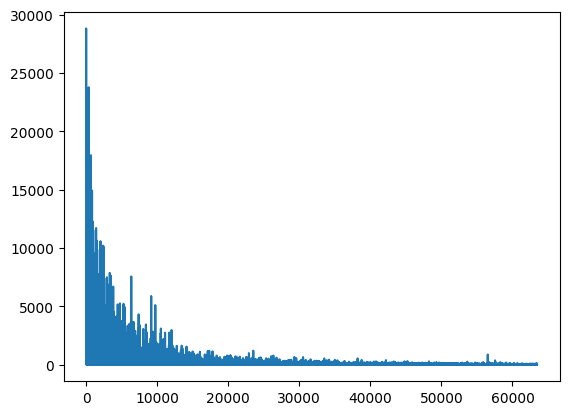

In [17]:
counter = Counter(words)
plt.plot(range(len(counter.keys())), counter.values())
plt.show()

In [18]:
num_samples = 50
test_indexes = np.random.choice(range(100, 20000), size=(num_samples))
test_words = [list(counter.keys())[i] for i in test_indexes]

print("Five of the picked test words: ", test_words[:5])

Five of the picked test words:  ['terrible', 'airport', 'laotian', 'dsm', 'unpopularity']


In [19]:
test_dict = {x : {"pos" : list(), "neg" : list()} for x in test_words}
window_size = 3
neg_sample = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    test_dict[w]["pos"].extend(ctx_samples)
    neg_size = len(ctx_samples) * neg_sample
    test_dict[w]["neg"].extend(random.choices(words, k = neg_size))

nr_contexts , nr_noises = 100 , 100
test_dict = {key: {"pos" :  [i[0] for i in Counter(value["pos"]).most_common(nr_contexts)], "neg" : [i[0] for i in Counter(value["neg"]).most_common(nr_noises)]} for key, value in test_dict.items()}
print(list(test_dict.items())[0])

('terrible', {'pos': ['ivan', 'tsar', 'war', 'conditions', 'realize', 'next', 'first', 'blow', 'iv', 'death', 'told', 'century', 'known', 'falsified', 'evidence', 'logic', 'question', 'great', 'suffered', 'man', 'achilles', 'said', 'living', 'battle', 'things', 'people', 'position', 'reputation', 'fire', 'winter', 'enfant', 'night', 'atrocities', 'god', 'typically', 'since', 'life', 'sonnets', 'suffering', 'wrath', 'government', 'committed', 'abuses', 'often', 'made', 'words', 'end', 'russia', 'short', 'later', 'early', 'mentioned', 'earned', 'built', 'island', 'day', 'camp', 'power', 'falcon', 'closed', 'empire', 'sudden', 'series', 'ruth', 'season', 'black', 'established', 'boudica', 'news', 'voice', 'loss', 'time', 'always', 'introduction', 'history', 'caused', 'called', 'name', 'yet', 'weapon', 'gutenberg', 'entry', 'home', 'respect', 'truly', 'performance', 'subject', 'poor', 'last', 'events', 'richard', 'external', 'jokes', 'someone', 'portrait', 'queen', 'area', 'classic', 'face

# Model

In [20]:
models1 = [torch.load('models/v27/epoch_%d.torch' % (x), map_location=device) for x in range(0,7)]

## Stats

In [21]:
stats_table, stats_dict = get_stats(models1, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [22]:
print(stats_table)

+---------------+--------+--------+-------+--------+-------+--------+
|     Target    |   1    |   2    |   3   |   4    |   5   |   6    |
+---------------+--------+--------+-------+--------+-------+--------+
|    terrible   | 0.812  | 2.368  | 2.624 | -1.556 | 0.065 | 20.166 |
|    airport    | -4.525 | -1.941 | 3.594 | -2.584 | 0.209 | 20.584 |
|    laotian    | -3.227 | -1.332 | 2.861 | -1.896 | 0.103 | 13.996 |
|      dsm      | -2.444 | -0.070 | 4.067 | -2.374 | 0.143 | 16.902 |
|  unpopularity | -0.499 | 1.055  | 2.358 | -1.554 | 0.108 | 16.566 |
|     films     | -2.026 | 0.089  | 3.828 | -2.116 | 0.162 | 21.286 |
|    original   | -1.029 | -0.234 | 0.990 | -0.795 | 0.059 | 21.335 |
|  interrupted  | -0.610 | 0.240  | 1.682 | -0.850 | 0.044 | 20.235 |
|   pheromones  | -0.322 | 1.680  | 2.952 | -2.001 | 0.108 | 15.149 |
|   albanians   | -3.308 | -0.692 | 4.559 | -2.617 | 0.234 | 16.656 |
|    ravages    | -0.762 | 0.614  | 1.923 | -1.375 | 0.067 | 13.835 |
|     raise     | 1.

In [23]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.006] [2: -0.000] [3: 0.341] [4: 0.007] [5: 0.001] [6: 10.026] 
EPOCH #1 [1: -0.321] [2: 0.556] [3: 0.937] [4: -0.878] [5: 0.072] [6: 11.511] 
EPOCH #2 [1: -0.613] [2: 0.653] [3: 1.531] [4: -1.266] [5: 0.105] [6: 12.908] 
EPOCH #3 [1: -0.826] [2: 0.637] [3: 1.943] [4: -1.463] [5: 0.115] [6: 14.195] 
EPOCH #4 [1: -1.133] [2: 0.457] [3: 2.224] [4: -1.590] [5: 0.119] [6: 15.392] 
EPOCH #5 [1: -1.171] [2: 0.539] [3: 2.522] [4: -1.711] [5: 0.120] [6: 16.514] 
EPOCH #6 [1: -1.453] [2: 0.319] [3: 2.753] [4: -1.772] [5: 0.119] [6: 17.583] 


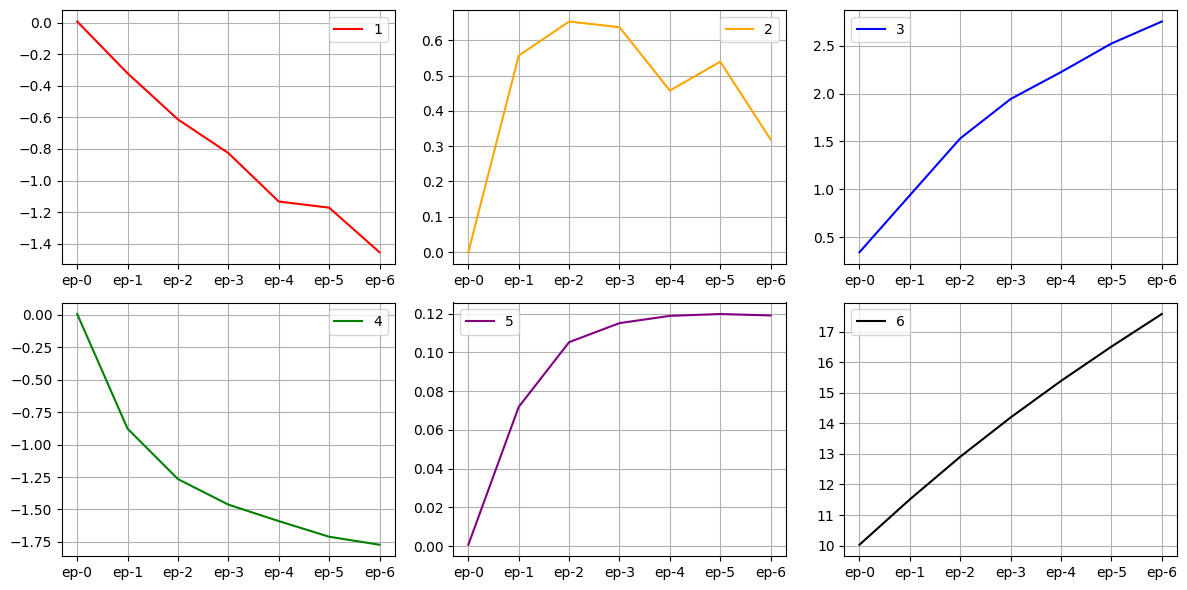

In [24]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [25]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['terrible', 'airport', 'laotian', 'dsm', 'unpopularity', 'films', 'original', 'interrupted', 'pheromones', 'albanians', 'ravages', 'raise', 'collapsed', 'hot', 'edward', 'billion', 'conquistadors', 'opium', 'floppy', 'monopoly']


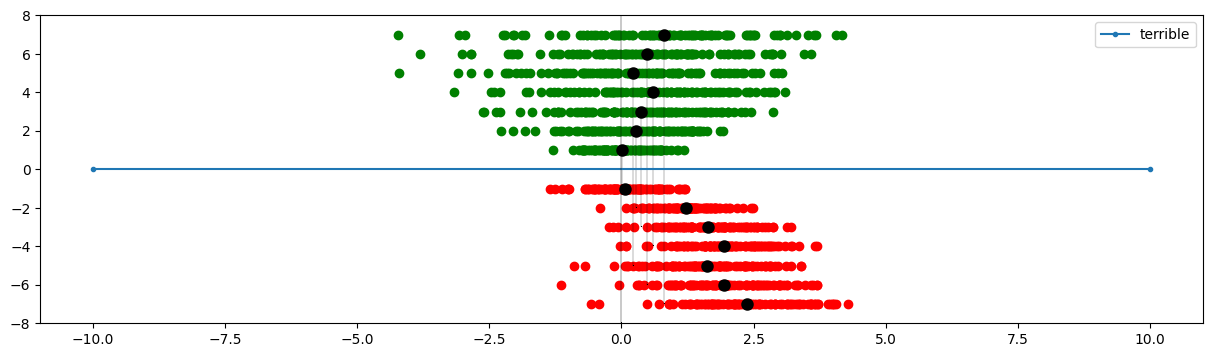

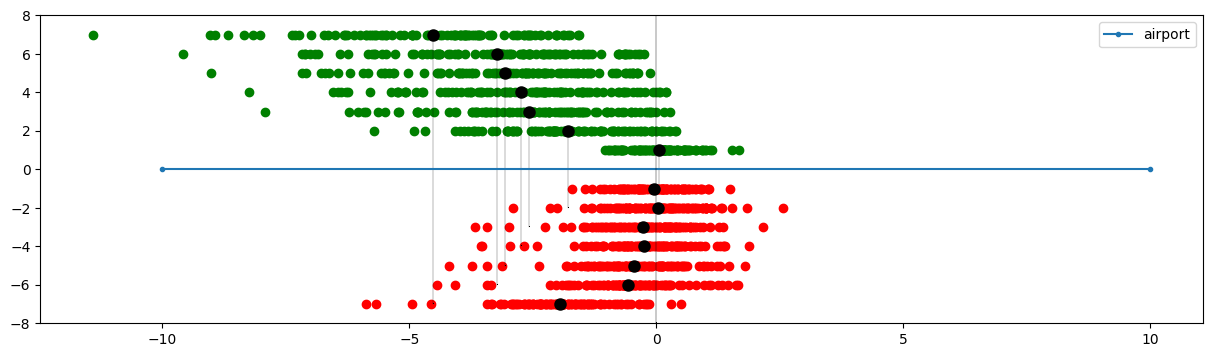

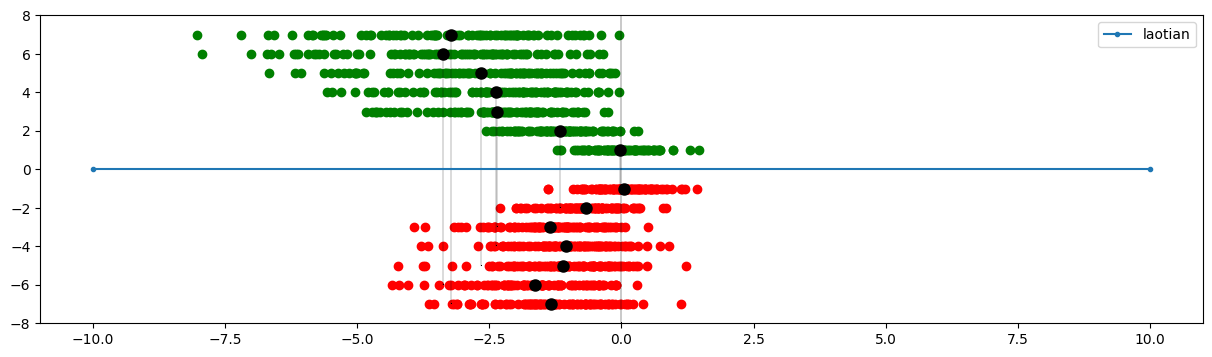

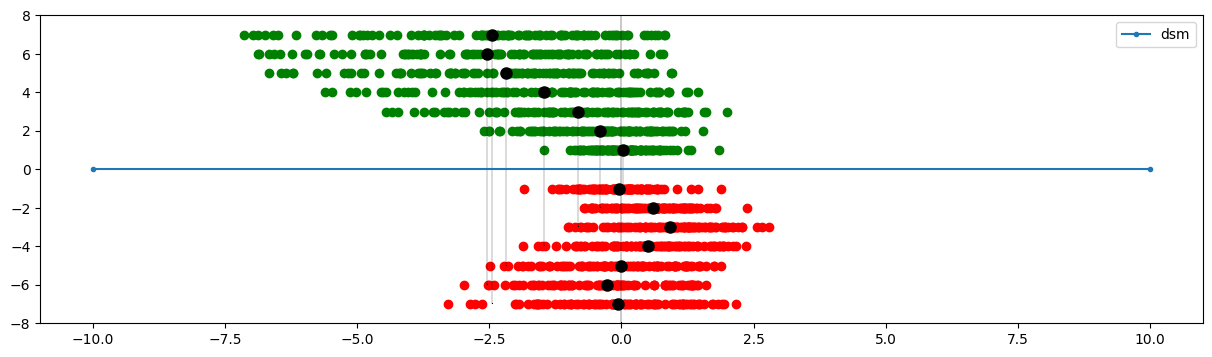

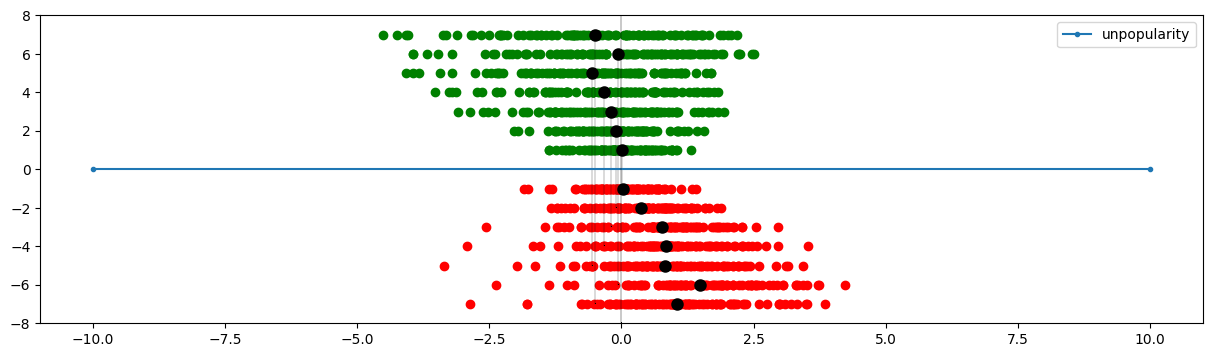

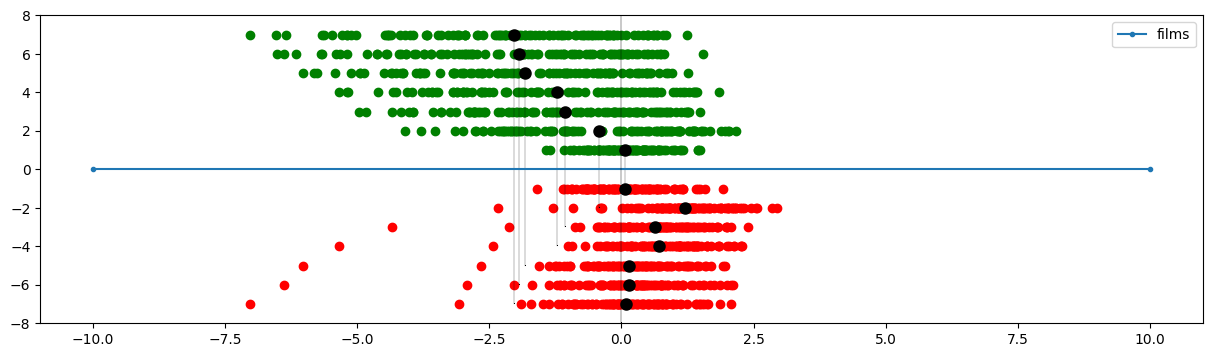

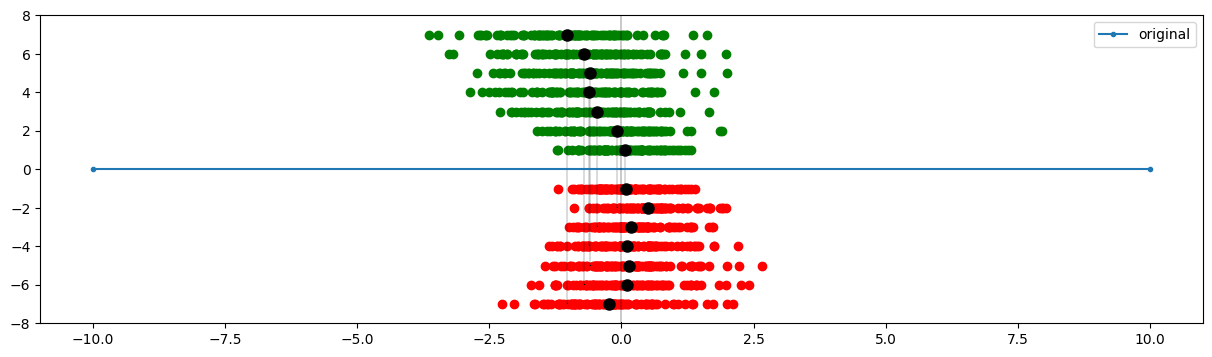

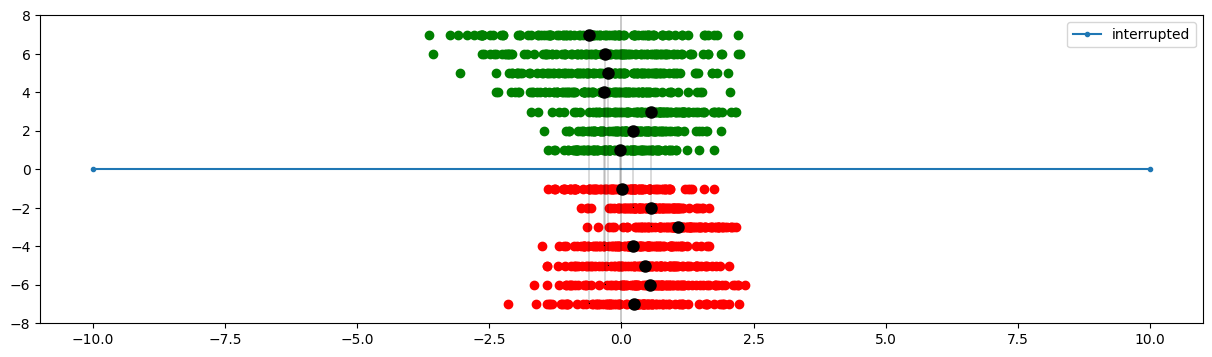

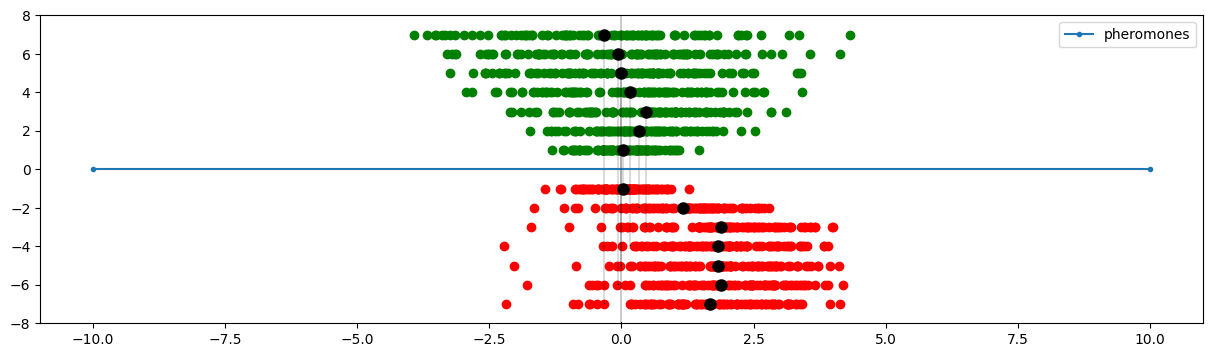

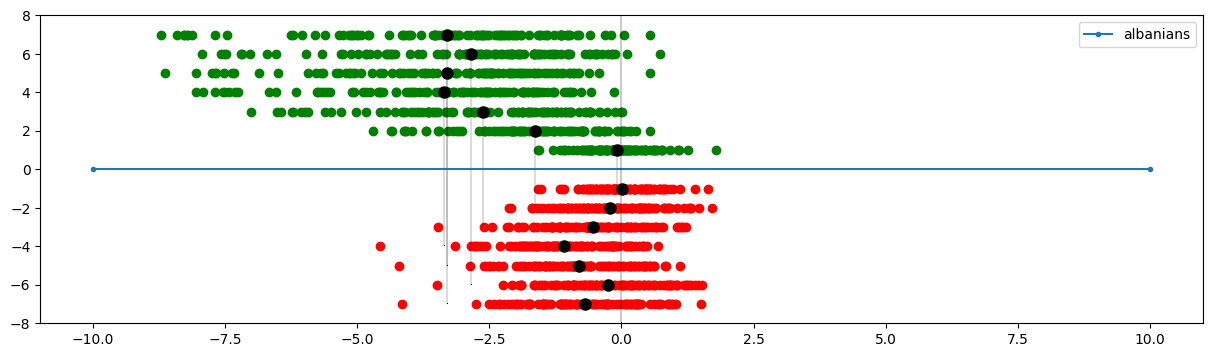

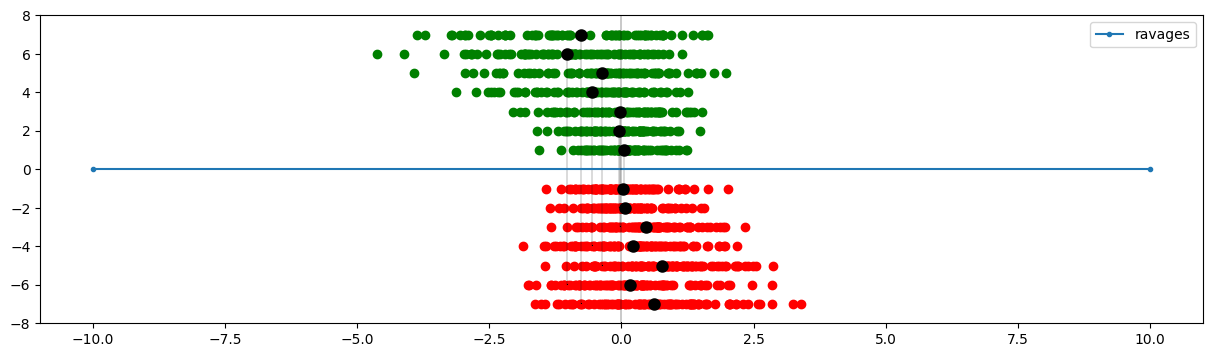

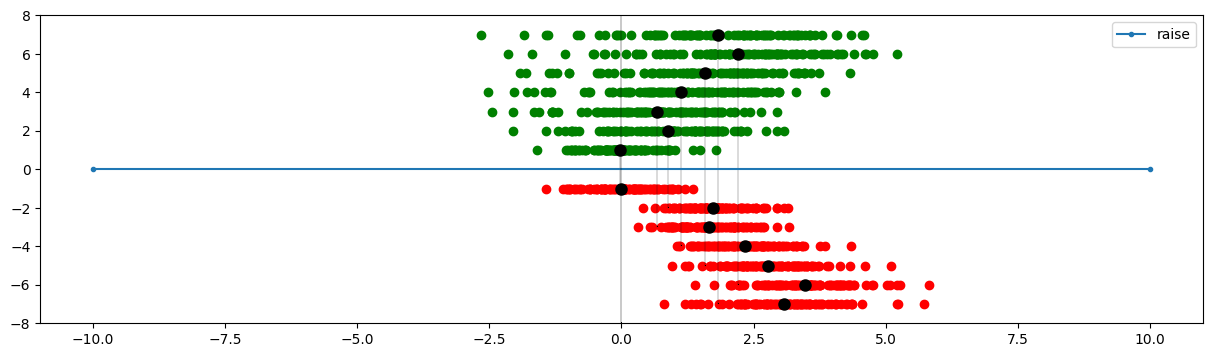

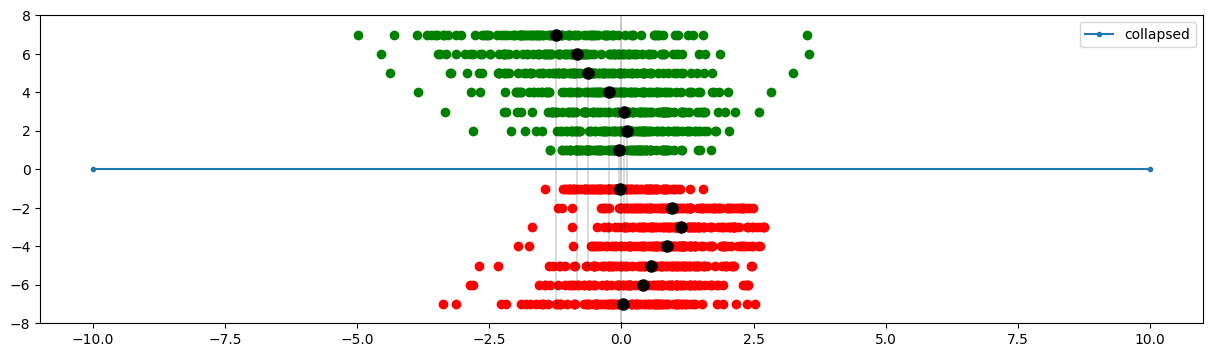

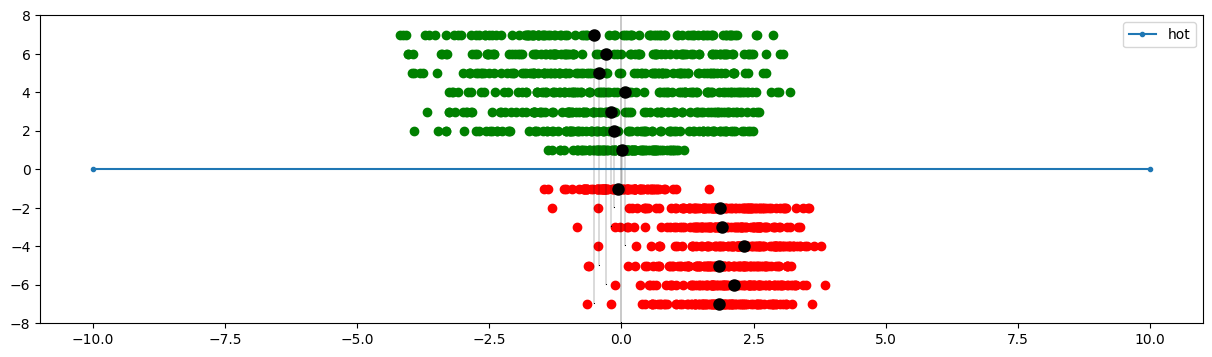

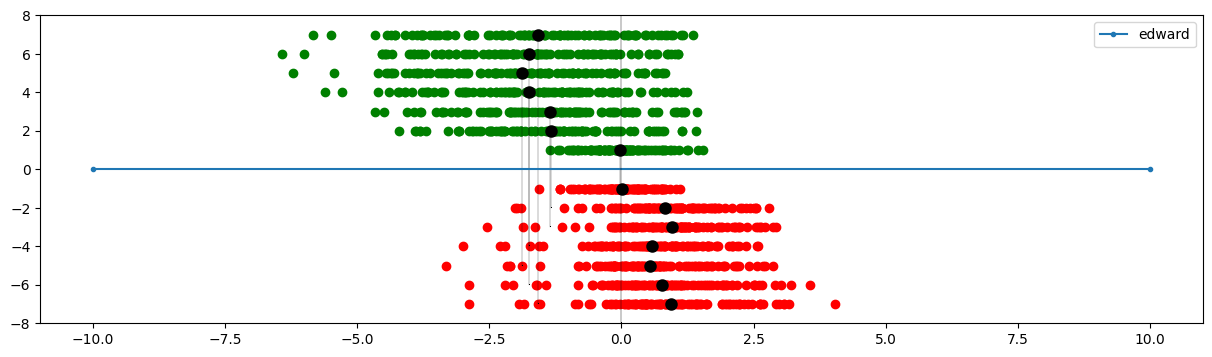

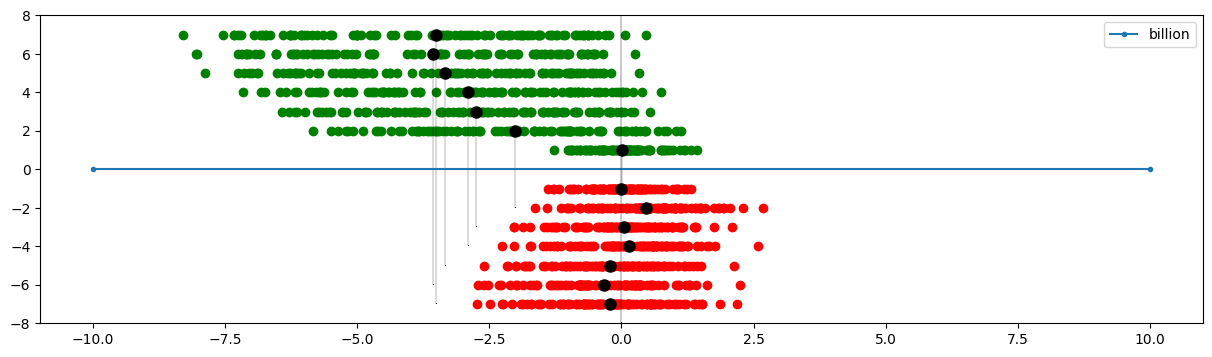

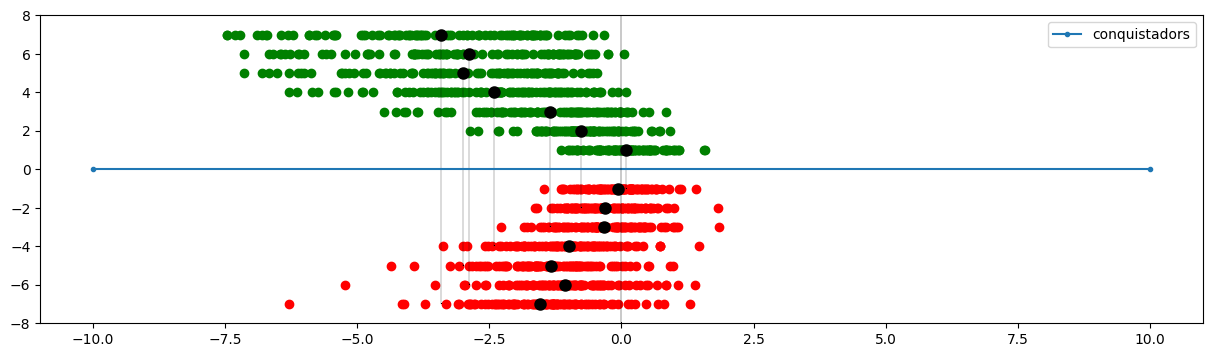

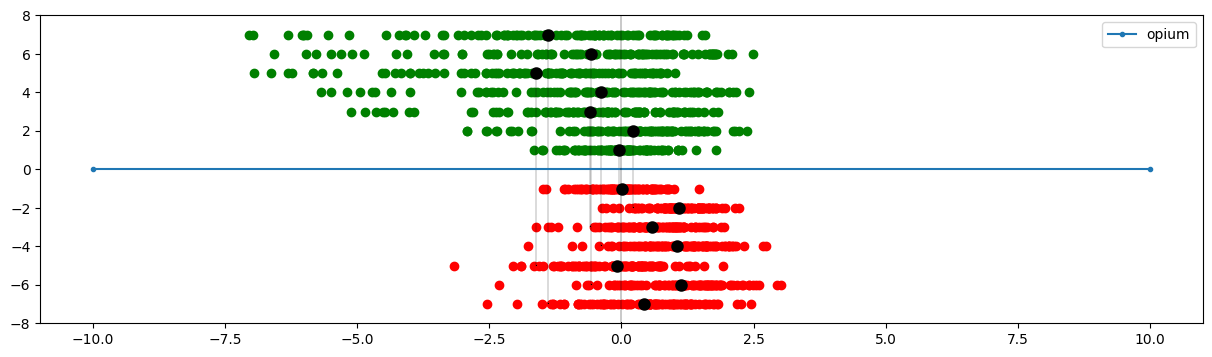

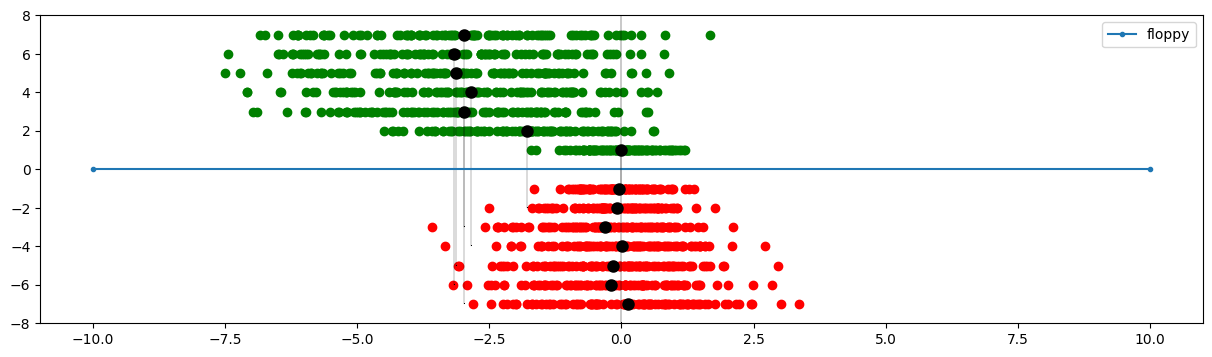

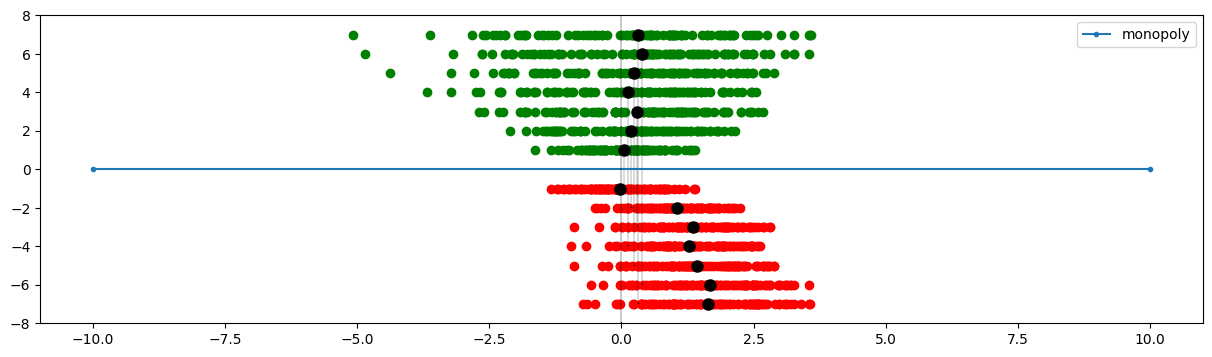

In [26]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models1)):
    target_vectors = models1[epoch].embedding_input_dictionary()
    context_vectors = models1[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 10.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [27]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models1))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models1)):

  trg_emb = models1[model_idx].embedding_input_dictionary()
  ctx_emb = models1[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.5628067758789252, 3: 0.5547659299285282, 4: 0.5413655223031162, 5: 0.5438621658969031, 6: 0.5492579390877701, 7: 0.5532623694162748, 8: 0.5561351723116624}

[MODEL #1] Progress: 50/50
 {2: 0.5822932418767853, 3: 0.5609061699790451, 4: 0.5623655682854363, 5: 0.5602970034620415, 6: 0.5606375634315512, 7: 0.561669145025353, 8: 0.5637250800977082}

[MODEL #2] Progress: 50/50
 {2: 0.5984604533476205, 3: 0.5567197765874756, 4: 0.5549538666239238, 5: 0.5581340395680919, 6: 0.5590693497390665, 7: 0.5632954039998572, 8: 0.5623454730237775}

[MODEL #3] Progress: 50/50
 {2: 0.5962377945672958, 3: 0.5518411501200425, 4: 0.5538302146169486, 5: 0.5528368282548966, 6: 0.5597118315105615, 7: 0.5554842962386967, 8: 0.5627626219486043}

[MODEL #4] Progress: 50/50
 {2: 0.5924666455405284, 3: 0.5549398521280433, 4: 0.5486687515228804, 5: 0.5525562755606287, 6: 0.554564239753073, 7: 0.5578974471224963, 8: 0.5651001293548314}

[MODEL #5] Progress: 50/50
 {2: 0.593221438135

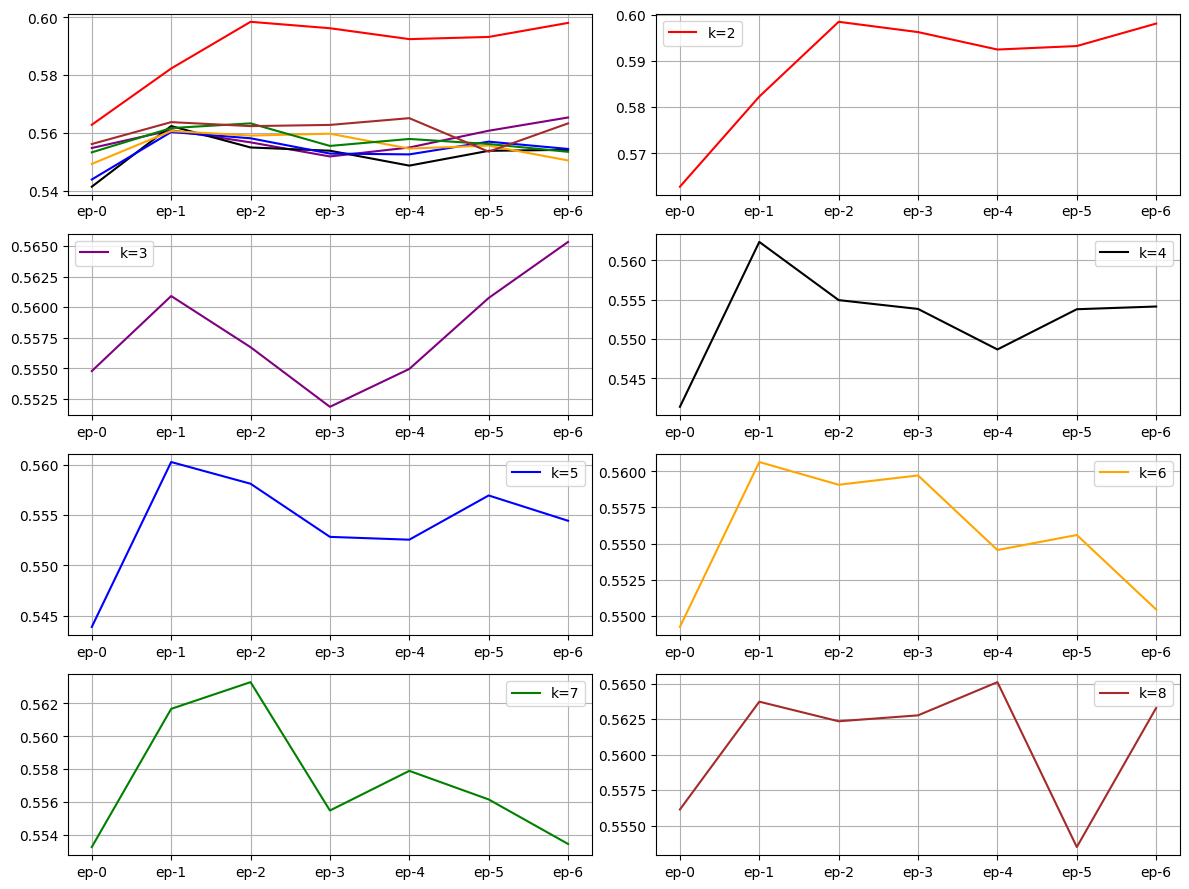

In [28]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [29]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+---------------+--------------------------------+-----------------------------------------------------------------+
|     Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+---------------+--------------------------------+-----------------------------------------------------------------+
|    terrible   |     [8, 2, 5, 7, 4, 7, 4]      | ['0.589', '0.625', '0.573', '0.578', '0.552', '0.573', '0.560'] |
|    airport    |     [5, 6, 7, 2, 8, 8, 8]      | ['0.601', '0.591', '0.584', '0.587', '0.628', '0.605', '0.603'] |
|    laotian    |     [8, 7, 5, 2, 2, 2, 6]      | ['0.576', '0.602', '0.619', '0.622', '0.583', '0.595', '0.590'] |
|      dsm      |     [2, 2, 3, 2, 2, 2, 2]      | ['0.563', '0.610', '0.590', '0.595', '0.618', '0.617', '0.604'] |
|  unpopularity |     [3, 5, 7, 6, 2, 2, 3]      | ['0.580', '0.580', '0.577', '0.586', '0.588', '0.583', '0.562'] |
|     films     |     [2, 2, 2, 2, 2, 2, 2]      | ['0.559', '0.

# DC

In [30]:
from google.colab import runtime
runtime.unassign()